In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib, os, random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [3]:
train_set = "../input/butterfly-images40-species/train"
test_set = "../input/butterfly-images40-species/test"
valid_set = "../input/butterfly-images40-species/valid"

# Printing Number of Classes
No_of_classes = os.listdir(train_set)
len(No_of_classes)

100

In [4]:
## Classes Name

data_dir = pathlib.Path(train_set)
categories = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(categories)

['ADONIS' 'AFRICAN GIANT SWALLOWTAIL' 'AMERICAN SNOOT' 'AN 88' 'APPOLLO'
 'ARCIGERA FLOWER MOTH' 'ATALA' 'ATLAS MOTH' 'BANDED ORANGE HELICONIAN'
 'BANDED PEACOCK' 'BANDED TIGER MOTH' 'BECKERS WHITE'
 'BIRD CHERRY ERMINE MOTH' 'BLACK HAIRSTREAK' 'BLUE MORPHO'
 'BLUE SPOTTED CROW' 'BROOKES BIRDWING' 'BROWN ARGUS' 'BROWN SIPROETA'
 'CABBAGE WHITE' 'CAIRNS BIRDWING' 'CHALK HILL BLUE' 'CHECQUERED SKIPPER'
 'CHESTNUT' 'CINNABAR MOTH' 'CLEARWING MOTH' 'CLEOPATRA'
 'CLODIUS PARNASSIAN' 'CLOUDED SULPHUR' 'COMET MOTH' 'COMMON BANDED AWL'
 'COMMON WOOD-NYMPH' 'COPPER TAIL' 'CRECENT' 'CRIMSON PATCH'
 'DANAID EGGFLY' 'EASTERN COMA' 'EASTERN DAPPLE WHITE'
 'EASTERN PINE ELFIN' 'ELBOWED PIERROT' 'EMPEROR GUM MOTH'
 'GARDEN TIGER MOTH' 'GIANT LEOPARD MOTH' 'GLITTERING SAPPHIRE'
 'GOLD BANDED' 'GREAT EGGFLY' 'GREAT JAY' 'GREEN CELLED CATTLEHEART'
 'GREEN HAIRSTREAK' 'GREY HAIRSTREAK' 'HERCULES MOTH'
 'HUMMING BIRD HAWK MOTH' 'INDRA SWALLOW' 'IO MOTH' 'Iphiclus sister'
 'JULIA' 'LARGE MARBLE' 'LUNA MOTH

## Visualizing Images

In [5]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + '/' + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  return img

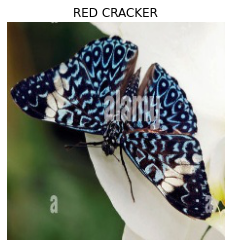

In [6]:
img = view_random_image(train_set,'RED CRACKER')

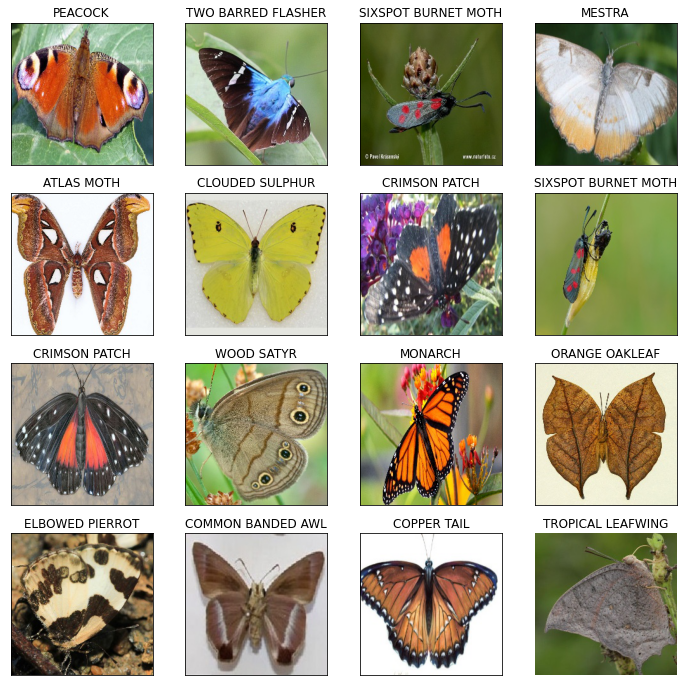

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(No_of_classes)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_set,No_of_classes[random_index[i]]))
    ax.set_title(No_of_classes[random_index[i]])

## Data Preprocessing

In [8]:
## Data Augmentation

SIZE_X = SIZE_Y =224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,
                                  shear_range=True,
                                  rotation_range=40)
train_set = datagen.flow_from_directory(train_set, class_mode = 'categorical',
                                        target_size = (SIZE_X , SIZE_Y),
                                        color_mode = 'rgb',
                                        batch_size = 32)

Found 12639 images belonging to 100 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1/255.)

validation_set = val_datagen.flow_from_directory(valid_set,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 500 images belonging to 100 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_set = test_datagen.flow_from_directory(test_set,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 500 images belonging to 100 classes.


## Model Building

## Resnet101

In [11]:
from keras.applications.resnet_v2 import ResNet101V2

In [12]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(224,224,3))

2022-11-14 02:38:42.629702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 02:38:42.722741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 02:38:42.723805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 02:38:42.725124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

171327488/171317808 [==============================] - 8s 0us/step


In [13]:
# don't train existing weights
for layer in resnet_v2.layers:
    layer.trainable = False

In [14]:
base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dropout(0.5)(base_model)
base_model = Dense(400,activation='relu')(base_model)
base_model = Dropout(0.5)(base_model)
base_model = Dense(100,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
history = model.fit(train_set,epochs=15,batch_size=48,validation_data=validation_set)

2022-11-14 02:40:29.897609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-14 02:40:36.518229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


395/395 [==============================] - 202s 483ms/step - loss: 5.2968 - accuracy: 0.0509 - val_loss: 4.2172 - val_accuracy: 0.1020
Epoch 2/15
395/395 [==============================] - 162s 411ms/step - loss: 4.4623 - accuracy: 0.0654 - val_loss: 4.3440 - val_accuracy: 0.0860
Epoch 3/15
395/395 [==============================] - 163s 413ms/step - loss: 4.4685 - accuracy: 0.0657 - val_loss: 4.1385 - val_accuracy: 0.1140
Epoch 4/15
395/395 [==============================] - 163s 413ms/step - loss: 4.4659 - accuracy: 0.0657 - val_loss: 4.2497 - val_accuracy: 0.0860
Epoch 5/15
395/395 [==============================] - 170s 431ms/step - loss: 4.4296 - accuracy: 0.0698 - val_loss: 4.3537 - val_accuracy: 0.1280
Epoch 6/15
395/395 [==============================] - 166s 420ms/step - loss: 4.4607 - accuracy: 0.0757 - val_loss: 4.2134 - val_accuracy: 0.1040
Epoch 7/15
395/395 [==============================] - 163s 412ms/step - loss: 4.4039 - accuracy: 0.0748 - val_loss: 4.1966 - val_accura

In [16]:
result = model.evaluate(validation_set,batch_size=48)
print("Test Accuracy ------>",result[1]*100)
print("Test Loss ------>",result[0])

16/16 [==============================] - 2s 104ms/step - loss: 4.0612 - accuracy: 0.1300
Test Accuracy ------> 12.999999523162842
Test Loss ------> 4.061164855957031


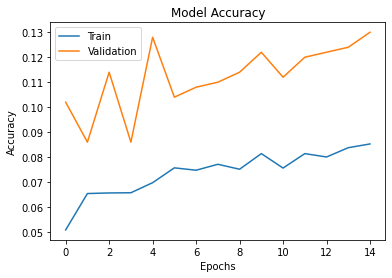

In [17]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

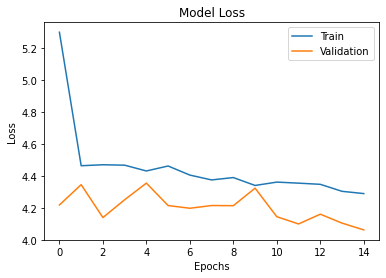

In [18]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

In [19]:
pred = model.predict(validation_set)
pred = np.argmax(pred,axis=1)

True Label: ATLAS MOTH
Predicted Label: IO MOTH


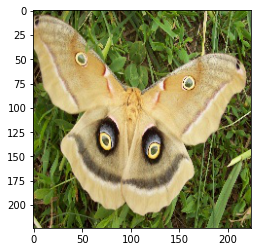

In [20]:
index =15

img , label = validation_set[index]
label = validation_set.labels[index]
print(f"True Label: {No_of_classes[label]}")
print(f"Predicted Label: {No_of_classes[pred[index]]}")  
plt.imshow(img[0])
plt.show()

## Custom Model

In [21]:
model_c = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(100, activation = 'softmax')
])

In [22]:
model_c.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#Train the model 
history = model_c.fit(train_set,
                    validation_data=test_set,
                    epochs = 20)

Epoch 1/20
395/395 [==============================] - 157s 394ms/step - loss: 3.5366 - accuracy: 0.1692 - val_loss: 5.5080 - val_accuracy: 0.0580
Epoch 2/20
395/395 [==============================] - 157s 397ms/step - loss: 2.3637 - accuracy: 0.3879 - val_loss: 1.8311 - val_accuracy: 0.5040
Epoch 3/20
395/395 [==============================] - 155s 393ms/step - loss: 1.8997 - accuracy: 0.4936 - val_loss: 1.5473 - val_accuracy: 0.5800
Epoch 4/20
395/395 [==============================] - 154s 390ms/step - loss: 1.5952 - accuracy: 0.5722 - val_loss: 1.0621 - val_accuracy: 0.7020
Epoch 5/20
395/395 [==============================] - 154s 391ms/step - loss: 1.4267 - accuracy: 0.6080 - val_loss: 0.9268 - val_accuracy: 0.7340
Epoch 6/20
395/395 [==============================] - 155s 391ms/step - loss: 1.2758 - accuracy: 0.6467 - val_loss: 0.9254 - val_accuracy: 0.7120
Epoch 7/20
395/395 [==============================] - 153s 386ms/step - loss: 1.1658 - accuracy: 0.6734 - val_loss: 0.7905 -

In [23]:
result_c = model_c.evaluate(validation_set,batch_size=32)
print("Test Accuracy ------>",result_c[1]*100)
print("Test Loss ------>",result_c[0])

16/16 [==============================] - 1s 83ms/step - loss: 0.5171 - accuracy: 0.8660
Test Accuracy ------> 86.59999966621399
Test Loss ------> 0.5171141028404236


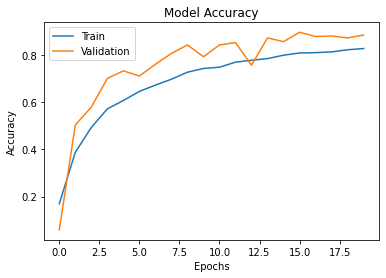

In [24]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

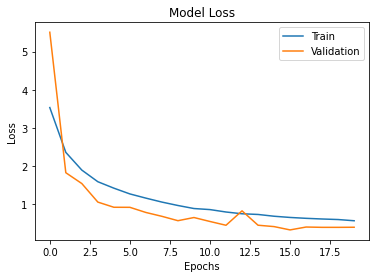

In [25]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

<AxesSubplot:xlabel='Models', ylabel='Accuracy'>

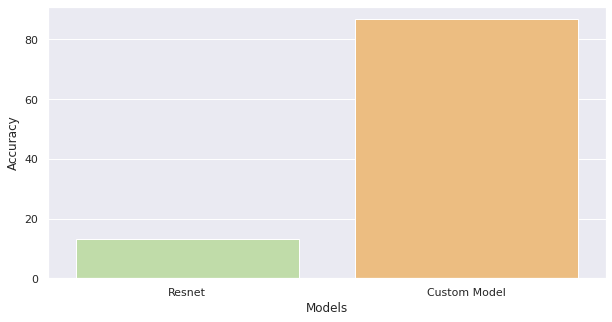

In [32]:
Models = pd.DataFrame({'Models':['Resnet', 'Custom Model'], 'Accuracy': [result[1]*100,result_c[1]*100]})
                                                                        
plt.figure(figsize=(10,5))
sns.set()
sns.barplot(Models['Models'], Models['Accuracy'],palette="Spectral_r")